In [337]:
import itertools
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [338]:
# Source: https://www.geeksforgeeks.org/python-program-to-get-all-subsets-of-given-size-of-a-set/
def findsubsets(polygon, n):
    """
    Computes the number of subsets that can be created.

    Args:
        polygon: The shape whose subsets we are seeking.
        n: The number of elements per subset

    Returns:
        A list of subsets of with each subset having a length of "n"
    """
    return list(itertools.combinations(polygon, n))

In [339]:
# def minimumSubset(A, subsets):
#     """
#     Finds the subset that best represents the polygon A
    
#     Args:
#         A: Polygon that we are seeking to replicate
#         subsets: A list of subsets 

#     Returns:
#         A list of subsets of with each subset having a length of "n"
#     """
#     d_min = math.inf
#     subset_min = 0
#     i = 0
#     while i < len(subsets):
#         j = 0
#         d = 0
#         while j < len(A):
#             result = np.array(A[j]) - np.array(subsets[i][j])
#             d = d + (np.sum(np.square(result)))
#             j += 1
#         i += 1

#         if (d < d_min):
#             d_min = d
#             subset_min = i
#     return subset_min, d_min

In [340]:
def minimumSubset(A, subsets):
    """
    Finds the subset that best represents the polygon A
    
    Args:
        A: Polygon that we are seeking to replicate
        subsets: A list of subsets 

    Returns:
        A list of subsets of with each subset having a length of "n"
    """
    d_min = math.inf
    subset_min = 0
    i = 0
    n = len(A)
    
    for i in range(0, n):
        for l in range(0, 2):
            d = 0
            for j in range(0, n):
                current_x = A[j]
                
                # Use foward cycling if 0
                # Use reverse cycling if 1                    
                current_y = subsets[(i + j) % n] if l == 0 else subsets[(i - j) % n]
                result = np.array(current_x) - np.array(current_y) 
                d = d + (np.sum(np.square(result))) # Calculate the euclidean distance
            
            if (d < d_min):
                d_min = d
                i_min = i
                
            
    return i_min, d_min

In [341]:
def getEquationCoeffs(segments_A):
    """
    Finds the linear equations for the segements of a polygon. These segments are in a form of Ax+By+C=0.
    
    Args:
        segments_A: Segments of a polygon

    Returns:
        A list of the coefficients mainly, A, B and C for every linear equation formed using the segments.
    """
    equations_coeffs = [] # Ax + By + C = 0, A = index 0, B = index 1, C = index 2

    for segment in segments_A:
        if (segment[0][0] == segment[1][0]):
            equations_coeffs.append([1, 0, -segment[0][0]])
        elif (segment[0][1] == segment[1][1]):
            equations_coeffs.append([0, 1, -segment[0][1]])
        else:
            slope = (segment[1][1] - segment[0][1]) / (segment[1][0] - segment[0][0])
            y_intercept = segment[0][1] - slope * segment[0][0]
        
            # Assuming the coefficient for y will always be one, since we just rearranging y=mx+c
            # Multiplying by -1 for rearrangement purposes
            equations_coeffs.append([(slope * -1), 1, (y_intercept * -1)]) 
    return equations_coeffs

In [342]:
def findDistanceToLine(x, y, equationList):
    """
    Finds the distance from a point (x,y) to the segments of a polygon.
    
    Args:
        x: The 'x' value of the coordinate
        y: The 'y' value of the coordinate
        equationList: A list of coefficients (A, B, C) from Ax+By+C=0 for all 
                      linear equations representing the line segments of a polygon.

    Returns:
        A list of the distances from the point (x,y) to every equation.
    """
    distanceList = {}
    for coeffs in equationList:
        A, B, C = coeffs
        distance = abs((A * x + B * y + C)) / (math.sqrt(A**2 + B**2))
        distanceList[distance] = coeffs
    
    return distanceList

In [343]:
def getPointsPerFrame(polygon_A, polygon_B, numberOfFrames):
    """
    Gets the number of points that we need to interpolate over per frame.
    
    Args:
        polygon_A: Our initial state of the polygon
        polygon_B: Our final state of the polygon
        numberOfFrames: The number of frames we want to interpolate over

    Returns:
        A list of integers, each representing the number of points we need in polygon_A at frame x to 
        make it to our final state.
    """
    n = len(polygon_B)
    m = len(polygon_A)
    
    pointAmount = (n - m) / numberOfFrames
    
    pointPerFrame = []
    
    for i in range(1, numberOfFrames + 1):
        pointPerFrame.append(round((i * pointAmount) + m))
    
    return pointPerFrame

In [344]:
def removeVertex(vertex, segments, polygon_A):
    """
    Removes a vertex from the segments and the polygon
    
    Args:
        Vertex: The coordinate in the polygon that we want removed
        segments: The segments of polygon_A
        polygon_A: Polygon that we are seeking to remove the point from. 

    Returns:
        A list updated segments and polygon points where the vertex is removed
    """
    
    adjacentSegments = []
    newSegmentsList = []
    newSegment = []
    newPolygon = []
    
    # Find the adjacent segments
    for segment in segments:
        vertexInSegment = False
        for coordinate in segment:
            if((coordinate == vertex).all()):
                adjacentSegments.append(segment)
                vertexInSegment = True
        
        if(vertexInSegment is False):
            newSegmentsList.append(segment)
    
    # Create a new segment between the vertices adjacent to the vertex variable.
    for segment in adjacentSegments:
        for coordinate in segment:
            if(not (coordinate == vertex).all()):
                newSegment.append(list(coordinate))


    
    newSegmentsList.append(np.array(newSegment))
    
    # Remove coordinate from polygon_A
    for coordinate in polygon_A:
        if (not (coordinate == vertex).all()):
            newPolygon.append(coordinate)
    
    return np.array(newPolygon), newSegmentsList

In [345]:
def spatialInterpolate(polygon_A, polygon_B, segments_A, segments_B, operation):
    """
    Spatially interpolates polygon A to polygon B by adding a vertex over one frame.
    
    Args:
        polygon_A: The polygon that represents the starting polygon
        polygon_B: The polygon we want to have in our final frame
        segments_A: The segments of polygon_A
        segments_B: The segments of polygon_B

    Returns:
        A new polygon and a list of line segments of that polygon.
    """
    
    subsets = findsubsets(polygon_B, len(polygon_A))
    if(operation == '-'):
        subsets = findsubsets(polygon_A, len(polygon_B))

    subset_length = len(subsets)
    
    s_min = 0 
    distance = 0
    if(operation == '+'):
        s_min, distance = minimumSubset(polygon_A, subsets)
        
    if(operation == '-'):
        s_min, distance = minimumSubset(polygon_B, subsets)
    
    b_corr = np.array(subsets[s_min]) # the best correspondence for polygon "B"
    
    # https://stackoverflow.com/questions/69435359/fast-check-if-elements-in-array-are-within-another-array-2d
    S = polygon_B[(polygon_B[:, None] == b_corr).all(-1).any(-1) == False]
    if(operation == "-"):
        S = polygon_A[(polygon_A[:, None] == b_corr).all(-1).any(-1) == False]
    
    b_corr = np.array(b_corr)
    
    
    if (operation == '+'):
        smallestValues = {}
        i = 0
        for coordinate in S:
            x, y = coordinate
            equations_coeffs = getEquationCoeffs(segments_A)
            segmentDistances = findDistanceToLine(x, y, equations_coeffs)
            smallest_key = min(segmentDistances.keys())
            smallestValues[smallest_key] = segmentDistances[smallest_key]

        greatest_key = max(smallestValues.keys())
        greatest_segment = smallestValues[greatest_key]

        best_segment = segments_A[equations_coeffs.index(greatest_segment)]

        x1 = best_segment[0][0]
        x2 = best_segment[1][0]

        y1 = best_segment[0][1]
        y2 = best_segment[1][1]

        midpoint_x = (x1 + x2)/2 
        midpoint_y = (y1 + y2)/2

        newPoint = [midpoint_x, midpoint_y]


        # Add the new segments connecting the midpoint
        segments_A = segments_A.tolist() + [[best_segment[0].tolist(), newPoint]] + [[best_segment[1].tolist(), newPoint]]

        segments_A.remove(segments_A[equations_coeffs.index(greatest_segment)])
        # Add new midpoint to polygon
        polygon_A = np.array(polygon_A.tolist() + [newPoint])
    
    
    if (operation == '-'):
        greatestValues = {}
        coordinateValues = {}
        i = 0
        for coordinate in S:
            x, y = coordinate
            equations_coeffs = getEquationCoeffs(segments_A)
            
            segmentDistances = findDistanceToLine(x, y, equations_coeffs)
            greatest_key = max(segmentDistances.keys())
            greatestValues[greatest_key] = segmentDistances[greatest_key]
            coordinateValues[(x,y)] = greatest_key

        smallest_key = max(greatestValues.keys())
        smallest_segment = greatestValues[smallest_key]
        
        best_segment = segments_A[equations_coeffs.index(smallest_segment)]
    
        smallest_coordinate = None
        for key, val in coordinateValues.items():
            if val == smallest_key:
                smallest_coordinate = key
        
        polygon_A, segments_A = removeVertex(list(smallest_coordinate), segments_A, polygon_A)
        
    return np.array(polygon_A), np.array(segments_A)

In [358]:
x = 3 # Number of frames
operation = '-' # Monotonically decreasing

# CODE FOR MONOTONICALLY INCREASING POLYGON - change operation to '+' before running
# polygon_A = np.array([[0,0],[1,0],[0,2]]) # Polygon A
# polygon_B = np.array([[5,0], [0,4], [6,5], [7,5], [7,0]]) # Polygon B
# pointFrameList = getPointsPerFrame(polygon_A, polygon_B, x)
# segments_A = np.array([[[0,0], [0,2]], [[0,2], [1,0]], [[1,0], [0,0]]])
# segments_B = np.array([[[5,0], [0,4]], [[0,4], [6,5]], [[6,5], [7,5]], [[7,5], [7,0]], [[7,0], [5,0]]])


# CODE FOR MONOTONICALLY DECREASING POLYGON - change operation to '-' before running
polygon_A = np.array([[5,0], [0,4], [6,5], [7,5], [7,0]])
polygon_B = np.array([[0,0],[1,0],[0,2]]) # Polygon B
segments_A = np.array([[[5,0], [0,4]], [[0,4], [6,5]], [[6,5], [7,5]], [[7,5], [7,0]], [[7,0], [5,0]]])
segments_B = np.array([[[0,0], [0,2]], [[0,2], [1,0]], [[1,0], [0,0]]])



pointFrameList = getPointsPerFrame(polygon_A, polygon_B, x)

print("Points per frame: ")
print(pointFrameList)


for i in range(0, x):
    # If we are not adding or removing points
    if(len(polygon_A) == pointFrameList[i]):
        if(operation == '+'):
            minimumSubset(polygon_A, polygon_B)
        if(operation == '-'):
            minimumSubset(polygon_B, polygon_A)
    else:
        # If we decide to add/remove a point
        polygon_A, segments_A = spatialInterpolate(polygon_A, polygon_B, segments_A, segments_B, operation)
    print("Frame ", i, ": ", "Polygon -> ", polygon_A.tolist(), " Segments -> ", segments_A.tolist())

Points per frame: 
[4, 4, 3]
Frame  0 :  Polygon ->  [[5, 0], [0, 4], [6, 5], [7, 0]]  Segments ->  [[[5, 0], [0, 4]], [[0, 4], [6, 5]], [[7, 0], [5, 0]], [[6, 5], [7, 0]]]
Frame  1 :  Polygon ->  [[5, 0], [0, 4], [6, 5], [7, 0]]  Segments ->  [[[5, 0], [0, 4]], [[0, 4], [6, 5]], [[7, 0], [5, 0]], [[6, 5], [7, 0]]]
Frame  2 :  Polygon ->  [[5, 0], [0, 4], [7, 0]]  Segments ->  [[[5, 0], [0, 4]], [[7, 0], [5, 0]], [[0, 4], [7, 0]]]


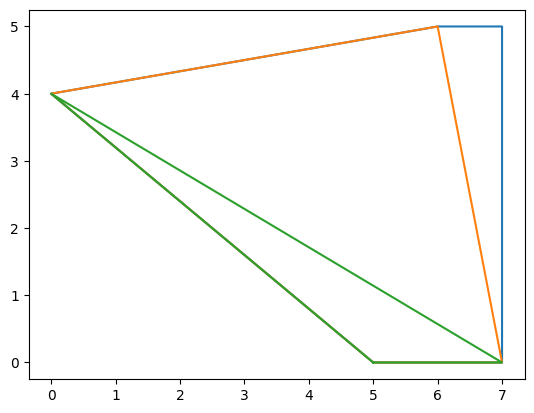

In [359]:
plt.plot([5, 0, 6, 7, 7, 5], [0, 4, 5, 5, 0, 0]) # Initial State

plt.plot([5, 0, 6, 7, 5], [0, 4, 5, 0, 0]) # Frame 0 and 1

plt.plot([5, 0, 7, 5], [0, 4, 0, 0]) # Frame 2 - Final Start

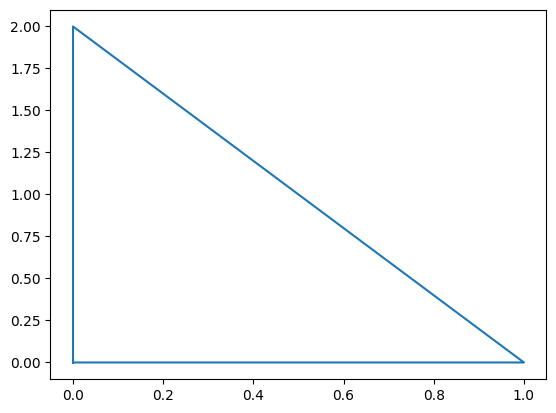

In [362]:
# Final State - Polygon B
plt.plot([0, 1, 0, 0], [0, 0, 2, 0])